In [1]:
import findspark
import os
findspark.init('/home/hadoop/spark')
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
conf = SparkConf().setAppName('Jupyter PySpark Exercise')
conf.set('spark.yarn.dist.files','file:/home/hadoop/spark/python/lib/pyspark.zip,file:/home/hadoop/spark/python/lib/py4j-0.10.7-src.zip')
conf.setExecutorEnv('PYTHONPATH','pyspark.zip:py4j-0.10.7-src.zip')
conf.setMaster('yarn') # Run on Yarn, not local
sc = SparkContext(conf=conf)

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [24]:
imdb_movie_dataframe = spark.read.format('com.databricks.spark.csv').options(delimiter = '\t',header ='true',nullValue ='null',inferSchema='true').load('hdfs:///user/hadoop/imdb_raw/title_basics/2018/12/7/title.basics.tsv')

In [5]:
imdb_movie_dataframe.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [9]:
from pyspark.sql.functions import col
movie_count = imdb_movie_dataframe.filter(col('titleType') == 'movie').count()

In [11]:
print movie_count

499667


In [13]:
imdb_people_dataframe = spark.read.format('com.databricks.spark.csv').options(delimiter = '\t',header ='true',nullValue ='null',inferSchema='true').load('hdfs:///user/hadoop/names.basics.tsv')

In [19]:
oldest_one = imdb_people_dataframe.filter(col('birthYear') != '\N').sort(col("birthYear").asc()).show(3)

+---------+------------------+---------+---------+--------------------+--------------------+
|   nconst|       primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+------------------+---------+---------+--------------------+--------------------+
|nm8572003|   Michael Vignola|     0001|       \N|composer,music_de...|tt6998038,tt40992...|
|nm0784172|Lucio Anneo Seneca|     0004|     0065|              writer|tt0218822,tt09725...|
|nm0194670|       Célina Cély|     0004|       \N|             actress|tt0043347,tt00560...|
+---------+------------------+---------+---------+--------------------+--------------------+
only showing top 3 rows



In [20]:
imdb_ratings_dataframe = spark.read.format('com.databricks.spark.csv').options(delimiter = '\t',header ='true',nullValue ='null',inferSchema='true').load('hdfs:///user/hadoop/imdb_raw/title_ratings/2018/12/7/title.ratings.tsv')

In [25]:
all_imdb_dataframe = imdb_ratings_dataframe.join(imdb_movie_dataframe, imdb_ratings_dataframe.tconst == imdb_movie_dataframe.tconst)

In [34]:
good_movies = all_imdb_dataframe.filter(col('numVotes') > 100000).filter(col('startYear') > 2000).filter(col('averageRating') > 8.0).filter(col('titleType') == 'movie')

In [35]:
good_movies.sort(col("averageRating").desc(),col("numVotes").desc()).select("originalTitle", "startYear", "averageRating", "numVotes").show(5)

+--------------------+---------+-------------+--------+
|       originalTitle|startYear|averageRating|numVotes|
+--------------------+---------+-------------+--------+
|     The Dark Knight|     2008|          9.0| 1971593|
|The Lord of the R...|     2003|          8.9| 1425695|
|           Inception|     2010|          8.8| 1752024|
|The Lord of the R...|     2001|          8.8| 1442541|
|The Lord of the R...|     2002|          8.7| 1288857|
+--------------------+---------+-------------+--------+
only showing top 5 rows



In [36]:
good_movies.sort(col("averageRating").desc(),col("numVotes").desc()).select("originalTitle", "startYear", "averageRating", "numVotes").write.format("csv").save("hdfs:///user/hadoop/good_movies") 
# saved on HDFS as /user/hadoop/good_movies/part-00000-f01c02b6-516a-4a28-9b7e-d271bfc47536-c000.csv
...

In [37]:
print good_movies.count()

79


In [38]:
plot_dataframe = good_movies.groupBy('startYear').count().sort(col("startYear").asc())

In [39]:
plot_dataframe.show()

+---------+-----+
|startYear|count|
+---------+-----+
|     2001|    6|
|     2002|    5|
|     2003|    4|
|     2004|    6|
|     2005|    2|
|     2006|    4|
|     2007|    4|
|     2008|    3|
|     2009|    6|
|     2010|    5|
|     2011|    5|
|     2012|    4|
|     2013|    4|
|     2014|    7|
|     2015|    4|
|     2016|    5|
|     2017|    3|
|     2018|    2|
+---------+-----+



In [40]:
import matplotlib.pyplot as plt
import pandas
pd_df=plot_dataframe.select("startYear", "count").toPandas()

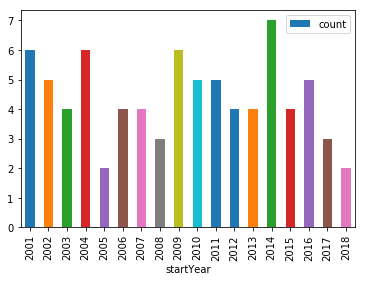

In [41]:
pd_df.plot.bar(x='startYear',y='count')